In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

import time
import pandas as pd
import numpy as np
import joblib

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from dask_ml.wrappers import ParallelPostFit

from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [2]:
df = pd.read_csv('../data/balanced_data_deduplicated.csv')
df.tail()

,short_descriptions,priority
242259,to sap in and bi bpc different price le,MEDIUM
242260,in share requests category service,MEDIUM
242261,failed online package,MEDIUM
242262,machine is offline hvd,MEDIUM
242263,to it in and ad be accounts idm active re need...,MEDIUM


In [3]:
vectorizer = joblib.load('../models/vectorizer_dd.pkl')
encoder = joblib.load('../models/encoder_dd.pkl')

In [4]:
df.isna().sum() / len(df) * 100

short_descriptions    0.006604
priority              0.000000
dtype: float64

In [5]:
df.dropna(inplace=True)

In [6]:
df = df.sample(frac=1)

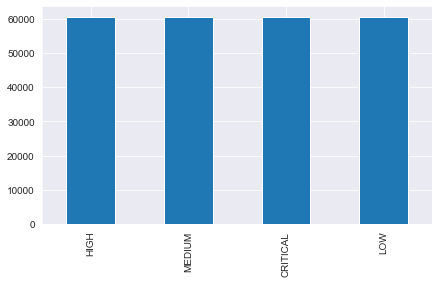

In [7]:
df['priority'].value_counts().plot(kind='bar', figsize=(7, 4))
plt.show()

In [8]:
X = df['short_descriptions'].values
y = df['priority'].values

In [9]:
X

array(['sog unmapped sos case empty of in', 'vbfa repaired bp be to',
       'to connect server unable', ...,
       'knil almone nokia pw ext com reset',
       'to not tasks do able schedule qg for in error cost standard releasing',
       'lost connection network vm instance'], dtype=object)

In [10]:
y

array(['LOW', 'LOW', 'HIGH', ..., 'LOW', 'CRITICAL', 'CRITICAL'],
      dtype=object)

In [11]:
%%time
X = vectorizer.transform(X)

Wall time: 3.11 s


In [12]:
%%time
y = encoder.transform(y.astype(str))

Wall time: 147 ms


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [14]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(193798, 29450) (193798,) (48450, 29450) (48450,)


In [15]:
models = [
    MultinomialNB(),
    LogisticRegression(n_jobs=-1),
    RandomForestClassifier(n_jobs=-1),
    LinearSVC(),
    DecisionTreeClassifier()
]


def display_metrics(true, pred):
    f1 = round(f1_score(y_true=true, y_pred=pred, average='weighted') * 100, 2)
    precision = round(precision_score(y_true=true, y_pred=pred, average='weighted') * 100, 2)
    recall = round(recall_score(y_true=true, y_pred=pred, average='weighted') * 100, 2)
    acc = round(accuracy_score(y_true=y_test, y_pred=preds) * 100, 2)

    print(f'Accuracy: {acc} | F1: {f1} | Precision: {precision} | Recall: {recall}')
    
    return acc, f1, precision, recall

In [16]:
%%time

trained_models = dict()

for model in models:
    model_name = model.__class__.__name__
    print(f'Training -> {model_name}')
    
    s = time.time()
    
    predictor = ParallelPostFit(estimator=model)
    predictor.fit(X_train, y_train)
    
    e = time.time()
    
    print(f'Training time: {round(e - s)} seconds')
    
    preds = predictor.predict(X_test)
    
    acc, f1, precision, recall = display_metrics(true=y_test, pred=preds)
    
    trained_models[f1] = predictor   
    
    print('-' * 50)
    
final_model = max(sorted(trained_models.items(), reverse=True))[1]
print('Best model: ', final_model)

Training -> MultinomialNB
Training time: 0 seconds
Accuracy: 74.73 | F1: 74.26 | Precision: 74.85 | Recall: 74.73
--------------------------------------------------
Training -> LogisticRegression
Training time: 19 seconds
Accuracy: 78.54 | F1: 78.18 | Precision: 78.17 | Recall: 78.54
--------------------------------------------------
Training -> RandomForestClassifier
Training time: 1121 seconds
Accuracy: 88.5 | F1: 88.34 | Precision: 88.39 | Recall: 88.5
--------------------------------------------------
Training -> LinearSVC
Training time: 10 seconds
Accuracy: 80.61 | F1: 80.18 | Precision: 80.34 | Recall: 80.61
--------------------------------------------------
Training -> DecisionTreeClassifier
Training time: 114 seconds
Accuracy: 83.37 | F1: 83.07 | Precision: 82.96 | Recall: 83.37
--------------------------------------------------
Best model:  ParallelPostFit(estimator=RandomForestClassifier(n_jobs=-1))
Wall time: 21min 7s


In [30]:
test = np.array([
    'mailbox shared add hr to user'
])

# True Label -> MEDIUM

test = vectorizer.transform(test)

In [31]:
prediction = final_model.predict(test)

In [32]:
encoder.inverse_transform([prediction])

array(['MEDIUM'], dtype=object)

In [33]:
display_metrics(true=y_train, pred=final_model.predict(X_train))

Accuracy: 87.31 | F1: 97.2 | Precision: 97.22 | Recall: 97.21


(87.31, 97.2, 97.22, 97.21)

In [34]:
report = classification_report(y_true=y_test, y_pred=final_model.predict(X_test), output_dict=True)

In [35]:
report_df = pd.DataFrame(report)

In [36]:
new_indices = list(
    encoder.inverse_transform(report_df.columns[:-3].astype('int'))
) + ['accuracy', 'macro avg', 'weighted avg']

In [37]:
report_df.columns = (new_indices)

In [38]:
report_df.T

,precision,recall,f1-score,support
CRITICAL,0.927004,0.969024,0.947548,16303.000000
HIGH,0.987302,0.997790,0.992518,16286.000000
LOW,0.822838,0.901219,0.860247,16167.000000
MEDIUM,0.891175,0.757566,0.818957,16355.000000
accuracy,0.906268,0.906268,0.906268,0.906268
macro avg,0.907080,0.906400,0.904818,65111.000000
weighted avg,0.907222,0.906268,0.904819,65111.000000


In [39]:
report_df.T.to_csv('../data/classification_report.csv')